# Microsoft Movie Analysis Project

## Project Summary

## Data Exploration & Prep


### Import Libraries


In [62]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# set display options to remove scientific notation and allow dataframe rows to display
#pd.options.display.float_format = '{:,.2f}'.format
pd.set_option("max_rows", None)

### Source Data Loads

In [2]:
# Load IMDB Basics as title master, set index and convert minutes from float
imdb_basics = pd.read_csv('data/imdb.title.basics.csv')
imdb_basics['runtime_minutes'] = imdb_basics['runtime_minutes'].astype('Int64')

# Load IMDB Ratings, set index, standarized column names and convert votes to integer
imdb_ratings = pd.read_csv('data/imdb.title.ratings.csv')
imdb_ratings.rename(columns={'averagerating': "avg_rating", 'numvotes': 'num_votes'}, inplace=True)
imdb_ratings['num_votes'] = imdb_ratings['num_votes'].astype('Int64')

# Load BOM Movie Gross, transform gross columns from mixed data types into integer
bom = pd.read_csv('data/bom.movie_gross.csv')
bom['domestic_gross'].replace('"', '', inplace=True)
bom['domestic_gross'].fillna(0, inplace=True)
bom['domestic_gross'] = bom['domestic_gross'].astype('Int64')
bom['foreign_gross'] = bom['foreign_gross'].str.replace(',', '')
bom['foreign_gross'].fillna(0, inplace=True)
bom['foreign_gross'] = bom['foreign_gross'].astype('float').round(0).astype('Int64')


### Data Profiling

#### IMDB Basics File

In [3]:
# IMDB Basics import and data quality check

print(imdb_basics.head(2))
imdb_basics.info() # Nulls 31K minutes, 5K genre
imdb_basics.duplicated(['tconst'],keep=False).sum() #No dups
imdb_basics.duplicated(['primary_title','start_year'],keep=False).sum() #3942 dups
imdb_basics['start_year'].value_counts(sort=True) #Ranges 2010 - 2019 partial (some future)
imdb_basics['genres'].value_counts(sort=True) #Majority single genres but 1085 combinations

      tconst                    primary_title   original_title  start_year  \
0  tt0063540                        Sunghursh        Sunghursh        2013   
1  tt0066787  One Day Before the Rainy Season  Ashad Ka Ek Din        2019   

   runtime_minutes              genres  
0            175.0  Action,Crime,Drama  
1            114.0     Biography,Drama  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   tconst           146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


Documentary                  32185
Drama                        21486
Comedy                        9177
Horror                        4372
Comedy,Drama                  3519
                             ...  
Mystery,News,Thriller            1
Family,History,Romance           1
History,News,War                 1
Animation,Music,Thriller         1
Biography,Fantasy,History        1
Name: genres, Length: 1085, dtype: int64

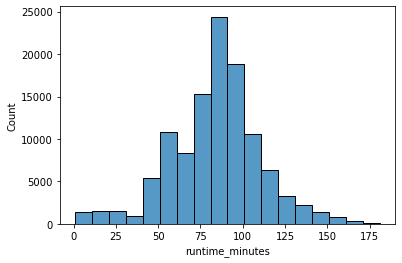

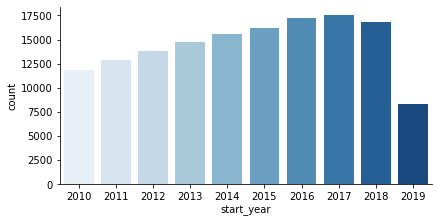

In [163]:
# Review distribution plots
length180 = imdb_basics[imdb_basics['runtime_minutes'] < 180]
sns.histplot(data=length180, x='runtime_minutes', binwidth=10, palette='Blues')

keepyears = imdb_basics[imdb_basics['start_year'].between(2010,2019)]
sns.catplot(data=keepyears, kind='count', x='start_year', palette='Blues', height=3, aspect=2)


In [141]:
movies['start_year'].value_counts()

2017    17505
2016    17272
2018    16849
2015    16243
2014    15589
2013    14709
2012    13788
2011    12900
2010    11849
2019     8379
2020      937
2021       83
2022       32
2023        5
2024        2
2027        1
2026        1
2025        1
2115        1
Name: start_year, dtype: int64

#### BOM Movie Gross File

In [4]:
# BOM Movie Gross File - explore data quality
print(bom.head(2))
print(bom.info()) # Nulls 31K minutes, 5K genre
print(bom.describe())
bom['year'].value_counts(sort=True) #Ranges 2010 - 2019 partial (some future)
bom['studio'].value_counts(sort=True) #Majority single genres but 1085 combinations

                        title studio  domestic_gross  foreign_gross  year
0                 Toy Story 3     BV       415000000      652000000  2010
1  Alice in Wonderland (2010)     BV       334200000      691300000  2010
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           3387 non-null   object
 1   studio          3382 non-null   object
 2   domestic_gross  3387 non-null   Int64 
 3   foreign_gross   3387 non-null   Int64 
 4   year            3387 non-null   int64 
dtypes: Int64(2), int64(1), object(2)
memory usage: 139.0+ KB
None
       domestic_gross  foreign_gross    year
count         3,387.0        3,387.0 3,387.0
mean     28,508,206.0   45,029,794.6 2,014.0
std      66,755,749.1  112,684,345.9     2.5
min               0.0            0.0 2,010.0
25%         111,500.0            0.0 2,012.0
50%       1,300,000.0    1,

IFC             166
Uni.            147
WB              140
Fox             136
Magn.           136
SPC             123
Sony            110
BV              106
LGF             103
Par.            101
Eros             89
Wein.            77
CL               74
Strand           68
FoxS             67
RAtt.            66
KL               62
Focus            60
WGUSA            58
CJ               56
MBox             54
UTV              50
A24              49
WB (NL)          45
FM               42
LG/S             41
Cohen            40
ORF              37
SGem             35
Rela.            35
FIP              26
Gold.            24
STX              24
GK               24
Osci.            23
TriS             23
RTWC             23
BST              22
MNE              22
EOne             21
Distrib.         20
Drft.            20
Relbig.          18
Anch.            18
CBS              17
Zeit.            16
BG               16
Sum.             15
FD               14
Yash             14


In [5]:
print(f"\n**{bom.duplicated(['title'],keep=False).sum()} duplicates found based on title**\n") #No dups
print(f"\n**{bom.duplicated(['title'],keep=False)} duplicates found based on title**\n") #No dups


**2 duplicates found based on title**


**0       False
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12      False
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20      False
21      False
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
30      False
31      False
32      False
33      False
34      False
35      False
36      False
37      False
38      False
39      False
40      False
41      False
42      False
43      False
44      False
45      False
46      False
47      False
48      False
49      False
50      False
51      False
52      False
53      False
54      False
55      False
56      False
57      False
58      False
59      False
60      False
61      False
62      False
63      False
64      False
65      False
66      False
67      False
68   

## Feature Engineering

### Extend IMDB Basics with Ratings 

In [14]:
# Create Movies DF - basics left join to ratings and bom 
movies = imdb_basics.merge(imdb_ratings, how='left', left_on='tconst', right_on='tconst', indicator='rating_ind')
movies.drop(columns=['original_title'], inplace=True)

movies = movies.merge(bom, how='left', left_on='primary_title', right_on='title', indicator='gross_ind')
movies.drop(columns=['title','year'], inplace=True)

movies['title_cnt'] = 1

movies.head(100)

,tconst,primary_title,start_year,runtime_minutes,genres,avg_rating,num_votes,rating_ind,studio,domestic_gross,foreign_gross,gross_ind,title_cnt
0,tt0063540,Sunghursh,2013,175,"Action,Crime,Drama",7.0,77,both,NaN,<NA>,<NA>,left_only,1
1,tt0066787,One Day Before the Rainy Season,2019,114,"Biography,Drama",7.2,43,both,NaN,<NA>,<NA>,left_only,1
2,tt0069049,The Other Side of the Wind,2018,122,Drama,6.9,4517,both,NaN,<NA>,<NA>,left_only,1
3,tt0069204,Sabse Bada Sukh,2018,<NA>,"Comedy,Drama",6.1,13,both,NaN,<NA>,<NA>,left_only,1
4,tt0100275,The Wandering Soap Opera,2017,80,"Comedy,Drama,Fantasy",6.5,119,both,NaN,<NA>,<NA>,left_only,1
5,tt0111414,A Thin Life,2018,75,Comedy,nan,<NA>,left_only,NaN,<NA>,<NA>,left_only,1
6,tt0112502,Bigfoot,2017,<NA>,"Horror,Thriller",4.1,32,both,NaN,<NA>,<NA>,left_only,1
7,tt0137204,Joe Finds Grace,2017,83,"Adventure,Animation,Comedy",8.1,263,both,NaN,<NA>,<NA>,left_only,1
8,tt0139613,O Silêncio,2012,<NA>,"Documentary,History",nan,<NA>,left_only,NaN,<NA>,<NA>,left_only,1
9,tt0144449,Nema aviona za Zagreb,2012,82,Biography,nan,<NA>,left_only,NaN,<NA>,<NA>,left_only,1


In [134]:
movies.groupby(['rating_ind','gross_ind']).size() # 98% have ratings, less than 5% have gross sales


rating_ind  gross_ind 
left_only   left_only     71949
            right_only        0
            both            339
right_only  left_only         0
            right_only        0
            both              0
both        left_only     70831
            right_only        0
            both           3027
dtype: int64

### IMDB Basics Genre

In [32]:
# Concatenate non-null genres series strings together in unique list
genres_list = ','.join(str(x) for x in imdb_basics['genres'].dropna().unique())
# Split genres list into unique set of genres
genres_unique = set(x for x in genres_list.split(','))

# Loop unique genres, create new boolean series for each genre; useful for correlations
for genre in sorted(genres_unique):
    imdb_basics['is_'+genre.lower()] = imdb_basics.apply(lambda x: int(genre in str(x.genres)), axis=1)

imdb_basics.head(50)

,tconst,primary_title,original_title,start_year,runtime_minutes,genres,is_action,is_adult,is_adventure,is_animation,...,is_news,is_reality-tv,is_romance,is_sci-fi,is_short,is_sport,is_talk-show,is_thriller,is_war,is_western
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,tt0111414,A Thin Life,A Thin Life,2018,75.0,Comedy,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,tt0112502,Bigfoot,Bigfoot,2017,NaN,"Horror,Thriller",0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7,tt0137204,Joe Finds Grace,Joe Finds Grace,2017,83.0,"Adventure,Animation,Comedy",0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
8,tt0139613,O Silêncio,O Silêncio,2012,NaN,"Documentary,History",0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,tt0144449,Nema aviona za Zagreb,Nema aviona za Zagreb,2012,82.0,Biography,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### IMDB Ratings

In [34]:

imdb_ratings.head()
imdb_ratings.info()
imdb_ratings.duplicated(['tconst'],keep=False).sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tconst         73856 non-null  object 
 1   averagerating  73856 non-null  float64
 2   numvotes       73856 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.7+ MB


0

## Business Analysis

### Best profit margins by genre

Profits = Worldwide Sales - Production Costs
Profit Margins = Profits / Production Costs
Notes: Sales and costs are adjusted by CPI factor, limited data sets have this data.

                             genres  Movie_Count  Subtotal  Pct_Total
693                     Documentary        32106    145083      22.13
793                           Drama        21306    145083      14.69
493                          Comedy         9096    145083       6.27
991                          Horror         4310    145083       2.97
526                    Comedy,Drama         3497    145083       2.41
1077                       Thriller         2985    145083       2.06
0                            Action         2164    145083       1.49
432           Biography,Documentary         2115    145083       1.46
871                   Drama,Romance         2069    145083       1.43
536            Comedy,Drama,Romance         1554    145083       1.07
694               Documentary,Drama         1552    145083       1.07
607                  Comedy,Romance         1502    145083       1.04
1060                        Romance         1443    145083       0.99
750               Do

[Text(0.5, 1.0, 'Movies By Genre Type 2010 through 2019')]

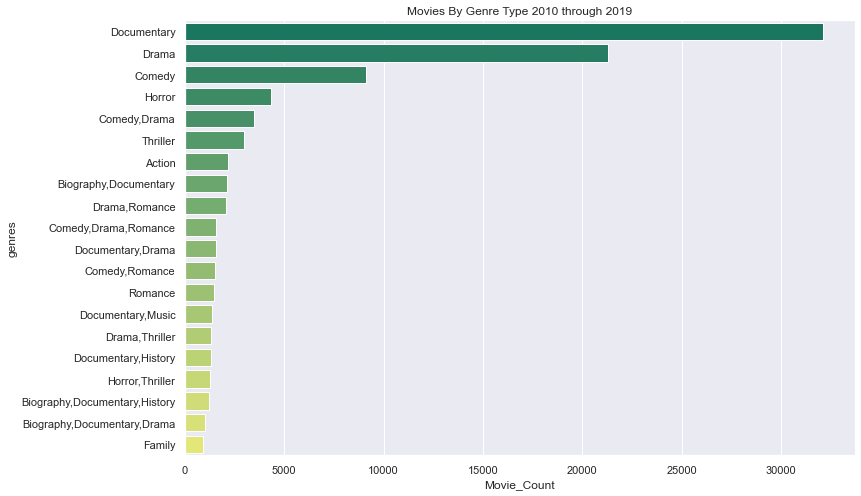

In [93]:
# Top movie genres 2010-2019
year_filter = movies['start_year'].between(2010,2019)
titles = movies[year_filter].groupby('genres', as_index=False).agg(Movie_Count = ('title_cnt', 'sum')).sort_values('Movie_Count', ascending=False)[:20]
titles['Subtotal'] = movies[year_filter].title_cnt.sum()
titles['Pct_Total'] = (titles['Movie_Count']*100 / titles['Subtotal'])
print(titles)

# Plot the top 20 genres by title count from 2010-2019
sns.set(rc={'figure.figsize':(12,8)})
sns.set_color_codes("muted")
ax = sns.barplot(data = titles, orient='h', x = 'Movie_Count', y = 'genres', palette='summer')
ax.set(title='Movies By Genre Type 2010 through 2019') # title barplot


In [90]:
titles['Pct_Total']

693    22.13
793    14.69
493     6.27
991     2.97
526     2.41
1077    2.06
0       1.49
432     1.46
871     1.43
536     1.07
694     1.07
607     1.04
1060    0.99
750     0.94
886     0.92
729     0.89
1012    0.86
436     0.85
433     0.71
892     0.64
Name: Pct_Total, dtype: float64

In [ ]:
#agg_rating = movies[movies['rating_ind']=True].groupby('genres', as_index=False).agg(Avg_Votes=('num_votes','mean'),
#                                                  Avg_Rating=('avg_rating','mean'))

## Deprecated Code

In [110]:
# IMDB Basics parse and featurize genres
def match_genre(target_genre, title_genres):
    result = 0
    if title_genres: 
        for genre in title_genres:
            if genre == target_genre: 
                result += 1
            else:     
                result += 0
    if result > 0: result = 1
    return result

unique_genres = sorted(imdb_basics['genres'].str.split(pat=",").explode().dropna().unique())
genre_series = imdb_basics['genres'].str.split(pat=",")

for key, genre in genre_series.head(50).items():
    for g in unique_genres:
        match = match_genre(g, genre)
        #print(genre, g, match)
        genre_series[key][g] = match #old method, had error on this line otherwise function working

imdb_basics.head(50)

TypeError: list indices must be integers or slices, not str